In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import time

df1 = pd.read_csv("Low_samples_Aug_RF.csv")
df2 = pd.read_csv("Mid_samples_RF.csv")
df3 = pd.read_csv("High_samples_Aug_RF.csv")
df = pd.concat([df1, df2, df3], ignore_index=True)

df.columns = df.columns.str.strip()

features = ['TotLen Fwd Pkts',
            'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
            'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
            'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
            'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Max',
            'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
            'Fwd Header Len', 'Pkt Len Max', 'Pkt Len Mean',
            'Pkt Len Std', 'Pkt Len Var', 'PSH Flag Cnt',
            'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
            'Subflow Fwd Byts', 'Subflow Bwd Byts',
            'Init Fwd Win Byts', 'Init Bwd Win Byts']

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

X = df[features]
y = df["Label"]
X = clean_dataset(X)
y = y[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

random_forest = RandomForestClassifier(random_state=42)
xgboost_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
adaboost_classifier = AdaBoostClassifier(random_state=42)
classifiers = [random_forest, xgboost_classifier, adaboost_classifier]



C:\Users\ghozz\AppData\Local\Temp\ipykernel_21208\2808169374.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [2]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_ensemble_f1_score = 0
best_meta_model = None
total_ensemble_f1_score = 0  # To accumulate F1-scores
total_base_model_training_time = 0
total_meta_model_training_time = 0
total_meta_model_inference_time = 0

for train_index, val_index in skf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    base_model_predictions = []

    # Measure training time for each base model
    base_model_training_times = []

    for classifier in classifiers:
        start_time = time.time()
        classifier.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        base_model_training_times.append(training_time)
        total_base_model_training_time += training_time

        predictions = classifier.predict(X_val)
        base_model_predictions.append(predictions)

    # Measure training time for the meta-model
    meta_feature_matrix = np.column_stack(base_model_predictions)

    meta_model = RandomForestClassifier(random_state=42)
    start_time = time.time()
    meta_model.fit(meta_feature_matrix, y_val)
    end_time = time.time()
    meta_model_training_time = end_time - start_time
    total_meta_model_training_time += meta_model_training_time

    base_model_test_predictions = []

    for classifier in classifiers:
        start_time = time.time()
        predictions = classifier.predict(X_scaled)
        end_time = time.time()
        inference_time = end_time - start_time
        base_model_test_predictions.append(predictions)

    meta_feature_matrix_test = np.column_stack(base_model_test_predictions)

    # Measure inference time for the meta-model
    start_time = time.time()
    final_predictions = meta_model.predict(meta_feature_matrix_test)
    end_time = time.time()
    meta_model_inference_time = end_time - start_time
    total_meta_model_inference_time += meta_model_inference_time

    ensemble_f1_score = f1_score(y_encoded, final_predictions, average='macro')

    total_ensemble_f1_score += ensemble_f1_score  # Accumulate F1-scores
    avg_ensemble_f1_score = total_ensemble_f1_score / n_splits

    if ensemble_f1_score > best_ensemble_f1_score:
        best_ensemble_f1_score = ensemble_f1_score
        best_meta_model = meta_model

    print("Ensemble F1-score for fold:", ensemble_f1_score)
    print("Base model training times:", base_model_training_times)
    print("Meta-model training time:", meta_model_training_time)
    print("Meta-model inference time:", meta_model_inference_time)

# Calculate the time taken per training sample and per inference sample
avg_base_model_training_time_per_sample = total_base_model_training_time / len(X_train)
avg_meta_model_training_time_per_sample = total_meta_model_training_time / len(X_train)
avg_meta_model_inference_time_per_sample = total_meta_model_inference_time / len(X_scaled)

print("Best Ensemble F1-score:", best_ensemble_f1_score)
print("Average Ensemble F1-score:", avg_ensemble_f1_score)
print("Average Base Model Training Time per Sample:", avg_base_model_training_time_per_sample)
print("Average Meta-Model Training Time per Sample:", avg_meta_model_training_time_per_sample)
print("Average Meta-Model Inference Time per Sample:", avg_meta_model_inference_time_per_sample)


Ensemble F1-score for fold: 0.9999940345020348
Base model training times: [29.716004848480225, 2.173461675643921, 29.788525104522705]
Meta-model training time: 1.286454677581787
Meta-model inference time: 2.379202127456665
Ensemble F1-score for fold: 0.9999940345020348
Base model training times: [30.182084321975708, 1.1173372268676758, 30.196643352508545]
Meta-model training time: 1.2870981693267822
Meta-model inference time: 2.4214675426483154
Ensemble F1-score for fold: 0.9999940345020348
Base model training times: [28.670918941497803, 1.2334740161895752, 30.387898683547974]
Meta-model training time: 1.3082735538482666
Meta-model inference time: 2.3433427810668945
Ensemble F1-score for fold: 0.9999940345020348
Base model training times: [28.743095874786377, 1.0608253479003906, 30.282143354415894]
Meta-model training time: 1.3727788925170898
Meta-model inference time: 2.4286391735076904
Ensemble F1-score for fold: 0.9999895603726277
Base model training times: [28.945820331573486, 1.20

In [3]:
(len(X_train)*0.0028283633383268227 )+ (len(X_train)*1.9917352765324936e-05)

1534.058345696011

In [4]:
avg_ensemble_f1_score = total_ensemble_f1_score / n_splits
print("Average Ensemble F1-score:", avg_ensemble_f1_score)

Average Ensemble F1-score: 0.9999931396761534


In [5]:
print("Average Overall Model Training Time per Sample:", avg_base_model_training_time_per_sample+ avg_meta_model_training_time_per_sample)

Average Overall Model Training Time per Sample: 0.000582708320209781


In [6]:
start_time = time.time()
best_meta_model_predictions_val = best_meta_model.predict(meta_feature_matrix)
end_time = time.time()
inference_time_val = end_time - start_time
print("Inference time for validation set:", inference_time_val, "seconds")


# Inverse transform to get original class labels for validation set
y_val_actual = le.inverse_transform(y_val)
best_meta_model_predictions_val_actual = le.inverse_transform(best_meta_model_predictions_val)

# Calculate and print the ensemble F1-score on the validation set
ensemble_f1_score_val = f1_score(y_val_actual, best_meta_model_predictions_val_actual, average='macro')
print("Ensemble F1-score on validation set:", ensemble_f1_score_val)


Inference time for validation set: 0.6845898628234863 seconds
Ensemble F1-score on validation set: 0.9999701722801047


In [7]:
# Calculate and print the classification report on the validation set
print("Classification Report on validation set:")
print(classification_report(y_val_actual, best_meta_model_predictions_val_actual))


Classification Report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71600
           1       1.00      1.00      1.00     63047

    accuracy                           1.00    134647
   macro avg       1.00      1.00      1.00    134647
weighted avg       1.00      1.00      1.00    134647



In [8]:
class_names = df['Label'].unique()

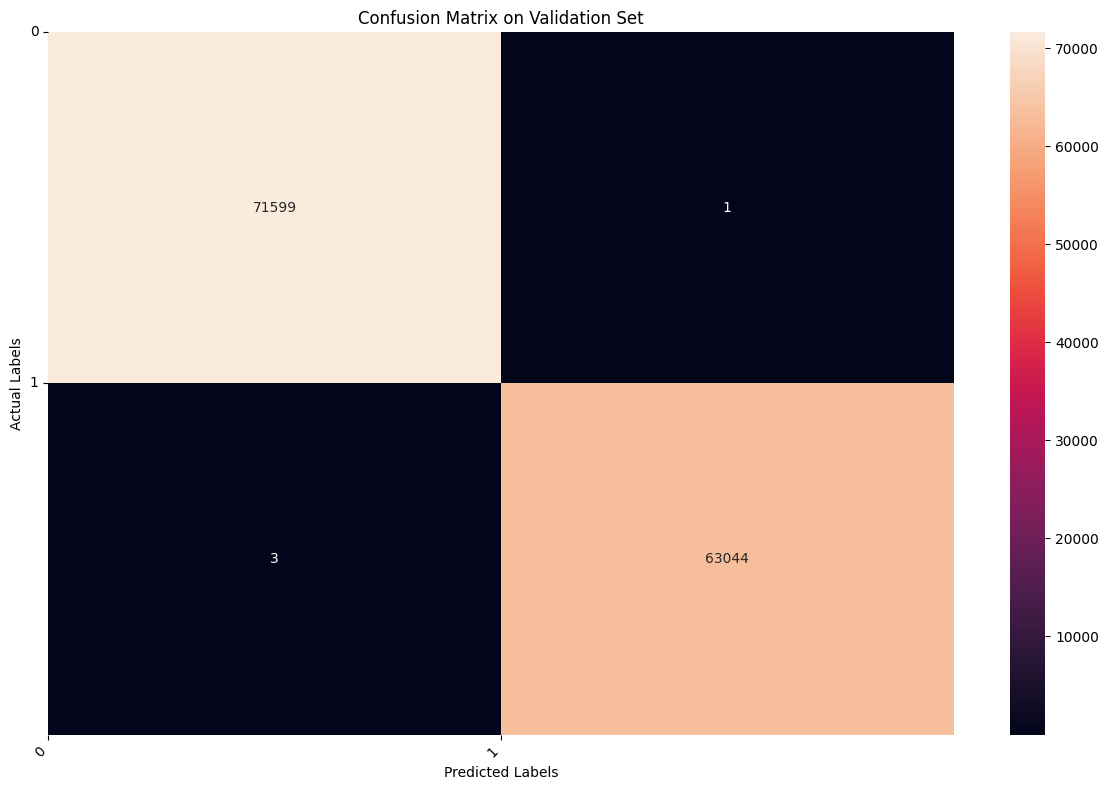

In [9]:
# Calculate and print the confusion matrix on the validation set
cm_val = confusion_matrix(y_val_actual, best_meta_model_predictions_val_actual)
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(cm_val, annot=True, fmt='.0f')
plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')  # Rotate and adjust alignment
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0, va='center')  # Adjust alignment
plt.tight_layout()  # Improve layout
plt.show()

In [10]:
import pickle

# Save the trained models, scaler, and encoder to a pickle file
trained_models = {
    'random_forest': random_forest,
    'xgboost_classifier': xgboost_classifier,
    'adaboost_classifier': adaboost_classifier,
    'meta_model': best_meta_model,
    'label_encoder': le,
    'scaler': scaler
}

with open('trained_models_updated_time.pkl', 'wb') as file:
    pickle.dump(trained_models, file)


## Test your custom file here using the trained model. 

#### Just change the file name and path of the model and testing file 

In [11]:
model_path= "trained_models_updated_time.pkl"
data_path = "union_dataset.csv"

In [12]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time

# Load the saved models and preprocessing objects from pickle file
with open(model_path, 'rb') as file:   
    trained_models = pickle.load(file)

# User provides the path to the test data CSV file

test_df = pd.read_csv(data_path)
test_df.columns = test_df.columns.str.strip()

# List of features used during training
test_features = ['TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Max',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd Header Len', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'PSH Flag Cnt',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts']

# Select features for testing
X_test = test_df[test_features]
Y_test= test_df["Label"]

# Clean and scale the test data using the saved scaler
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

X_test = clean_dataset(X_test)

Y_test = Y_test[X_test.index]

#Y_test = clean_dataset(Y_test)

X_test_scaled = trained_models['scaler'].transform(X_test)

start_time = time.time()

# Predict using the loaded models
random_forest = trained_models['random_forest']
xgboost_classifier = trained_models['xgboost_classifier']
adaboost_classifier = trained_models['adaboost_classifier']
meta_model = trained_models['meta_model']
label_encoder = trained_models['label_encoder']

# Generate predictions from the base models on the test data
start_time1 = time.time()
rf_predictions = random_forest.predict(X_test_scaled)
end_time1 = time.time()

start_time2 = time.time()
xgb_predictions = xgboost_classifier.predict(X_test_scaled)
end_time2 = time.time()

start_time3 = time.time()
ada_predictions = adaboost_classifier.predict(X_test_scaled)
end_time3 = time.time()


total_model_time=((end_time1-start_time1 )+(end_time2-start_time2)+(end_time3-start_time3))

print("Total model prediction time= :", total_model_time)


# Combine the predictions with the original features to create the new feature matrix for the meta-model
base_model_predictions = np.column_stack((rf_predictions, xgb_predictions, ada_predictions))

# Predict using the meta-model
start_time = time.time()  # Start timing for meta-model inference
final_predictions = meta_model.predict(base_model_predictions)
end_time = time.time()  # End timing for meta-model inference

total_inference_time = (end_time - start_time)+total_model_time
inference_time_per_sample = total_inference_time / len(X_test)

testing_time = end_time - start_time
print("Testing Time:", testing_time, "seconds")
print("Total Inference Time:", total_inference_time, "seconds")
print("Inference Time per Sample:", inference_time_per_sample, "seconds")


# Inverse transform to get original labels
final_predictions_actual = label_encoder.inverse_transform(final_predictions)

# Print the predicted labels for the user to see
print("Predicted labels:", final_predictions_actual)



C:\Users\ghozz\AppData\Local\Temp\ipykernel_21208\2699286462.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Total model prediction time= : 10.964199542999268
Testing Time: 3.45475435256958 seconds
Total Inference Time: 14.418953895568848 seconds
Inference Time per Sample: 1.44360172679796e-05 seconds
Predicted labels: [0 0 0 ... 0 0 0]


In [13]:
print("Count of label 1:", np.sum(final_predictions_actual == 1))
print("Count of label 0:", np.sum(final_predictions_actual == 0))

Count of label 1: 576111
Count of label 0: 422707


In [14]:
from sklearn.metrics import classification_report

# Load the true labels for the test data
true_labels = test_df["Label"]

# Calculate and print the classification report
classification_rep = classification_report(Y_test, final_predictions_actual)
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    422627
           1       1.00      1.00      1.00    576191

    accuracy                           1.00    998818
   macro avg       1.00      1.00      1.00    998818
weighted avg       1.00      1.00      1.00    998818



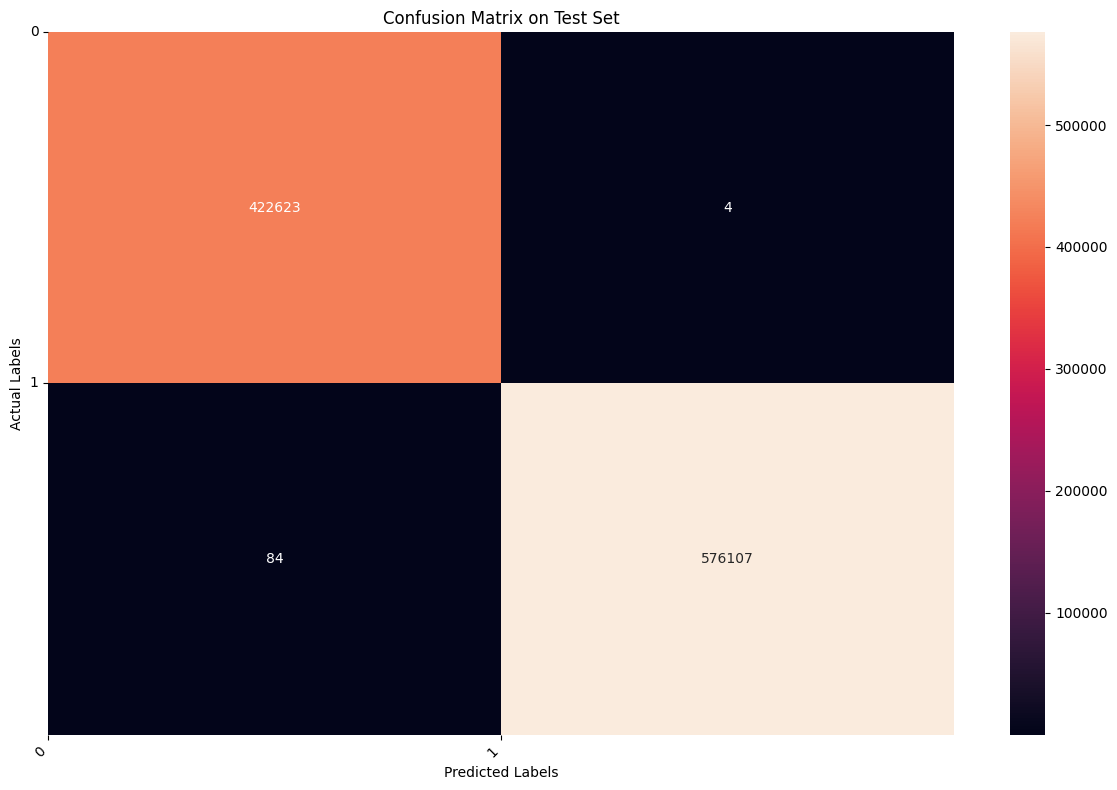

In [15]:
# Calculate and print the confusion matrix

#cm_test = confusion_matrix(Y_test, final_predictions_test_actual)
cm_test = confusion_matrix(Y_test, final_predictions_actual)

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(cm_test, annot=True, fmt='.0f')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')  
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0, va='center')  
plt.tight_layout()  
plt.show()



the next part remain unchanged

## Testing on CICIDS_2017 dataset

#### Dataset Link: https://drive.google.com/file/d/1OqBfuZNZTXFYyU3XWdS1HZpmP9MocQzq/view?usp=sharing

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time 

# Load the dataset from a CSV file
dataset_path = "CICIDS_2017.csv"
data = pd.read_csv(dataset_path)
data.columns = data.columns.str.strip()

X = data.drop("Label", axis=1)  
y = data["Label"]  

# Split the dataset into training (80%) and test (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Optionally, you can save the test set to a CSV file
test_set_path = "CICIDS_2017_test.csv"
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv(test_set_path, index=False)



In [17]:
model_path= "trained_models_updated_time.pkl"
data_path = "CICIDS_2017_test.csv"

In [18]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

# Load the saved models and preprocessing objects from pickle file
with open(model_path, 'rb') as file:   
    trained_models = pickle.load(file)

# User provides the path to the test data CSV file

test_df = pd.read_csv(data_path)
test_df.columns = test_df.columns.str.strip()

# List of features used during training
test_features = ['Total Length of Fwd Packets', 'Total Length of Bwd Packets',
            'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Bwd Packet Length Max',
            'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
            'Flow Packets/s', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean',
            'Fwd IAT Std', 'Fwd IAT Max', 'Fwd Header Length', 'Max Packet Length',
            'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
            'PSH Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size',
            'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Bytes',
            'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']

# Select features for testing
X_test = test_df[test_features]
Y_test= test_df["Label"]

# Clean and scale the test data using the saved scaler
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

X_test = clean_dataset(X_test)

Y_test = Y_test[X_test.index]

#Y_test = clean_dataset(Y_test)
X_test_scaled = trained_models['scaler'].transform(X_test)

start_time = time.time()

# Predict using the loaded models
random_forest = trained_models['random_forest']
xgboost_classifier = trained_models['xgboost_classifier']
adaboost_classifier = trained_models['adaboost_classifier']
meta_model = trained_models['meta_model']
label_encoder = trained_models['label_encoder']

# Generate predictions from the base models on the test data
rf_predictions = random_forest.predict(X_test_scaled)
xgb_predictions = xgboost_classifier.predict(X_test_scaled)
ada_predictions = adaboost_classifier.predict(X_test_scaled)

# Combine the predictions with the original features to create the new feature matrix for the meta-model
base_model_predictions = np.column_stack((rf_predictions, xgb_predictions, ada_predictions))

# Predict using the meta-model
final_predictions = meta_model.predict(base_model_predictions)

# Inverse transform to get original labels
final_predictions_actual = label_encoder.inverse_transform(final_predictions)
end_time = time.time()


# Print the predicted labels for the user to see
print("Predicted labels:", final_predictions_actual)

testing_time = end_time - start_time
print("Testing Time:", testing_time, "seconds")

/tmp/ipykernel_95221/273133750.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Predicted labels: ['BENIGN' 'BENIGN' 'BENIGN' ... 'BENIGN' 'BENIGN' 'BENIGN']
Testing Time: 22.34798789024353 seconds


In [19]:
from sklearn.metrics import classification_report

# Load the true labels for the test data
true_labels = test_df["Label"]

# Calculate and print the classification report
classification_rep = classification_report(Y_test, final_predictions_actual)
print("Classification Report:\n", classification_rep)


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454272
                       Bot       0.64      0.99      0.78       393
                      DDoS       1.00      1.00      1.00     25604
             DoS GoldenEye       0.99      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     46013
          DoS Slowhttptest       0.94      1.00      0.97      1100
             DoS slowloris       1.00      1.00      1.00      1159
               FTP-Patator       1.00      1.00      1.00      1586
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       0.83      0.71      0.77         7
                  PortScan       0.99      1.00      1.00     31764
               SSH-Patator       1.00      1.00      1.00      1179
  Web Attack � Brute Force       0.87      0.73      0.80       301
Web Attack � Sql Inject

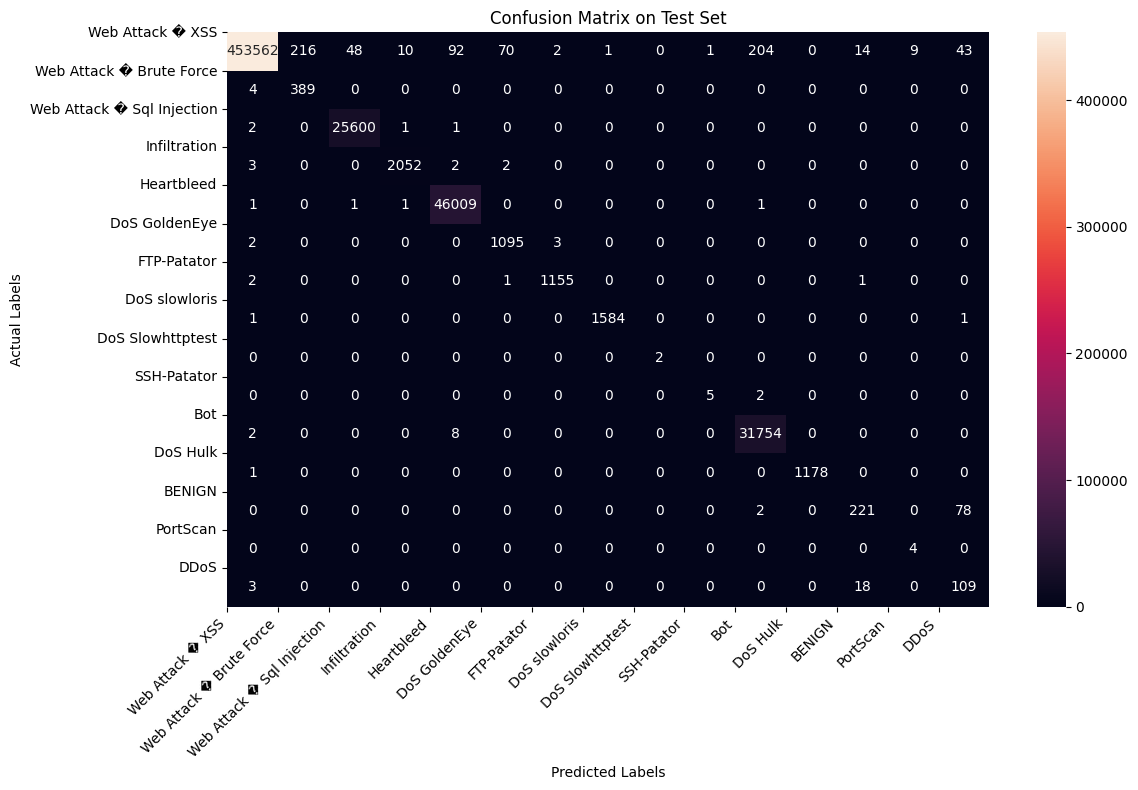

In [20]:
# Calculate and print the confusion matrix

#cm_test = confusion_matrix(Y_test, final_predictions_test_actual)
cm_test = confusion_matrix(Y_test, final_predictions_actual)

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(cm_test, annot=True, fmt='.0f')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')  
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0, va='center')  
plt.tight_layout()  
plt.show()

